In [ ]:
!pip3 install torch torchvision

In [1]:
import torch
import torchvision

In [ ]:
ls

sample_data/


In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'training'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
# sys.path.append('/content/drive/{}')

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/$FOLDERNAME/
# %cd /content/drive/$FOLDERNAME/

/content/drive/My Drive/training


In [ ]:
# !wget https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz

## Download Original Dataset

In [ ]:
# !tar xvzf CUB_200_2011.tgz

In [ ]:
# !cat CUB_200_2011/README

In [ ]:
# %cd drive/$FOLDERNAME

In [ ]:
# cd drive/MyDrive/CS682Project

## Import required libraries

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


In [5]:
import albumentations as A

## Helper Functions

read_image() functions reads image and converts it from BGR to RGB as opencv used BGR while matplotlib uses RGB. So, we need to make this conversion so we can easily visualize the data



In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [7]:
# Data Augmentation
import math

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode,
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)


In [8]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im/255.0 - imagenet_stats[0])/imagenet_stats[1]

In [ ]:
pwd

'/content/drive/My Drive/training'

In [9]:
PATH = Path('./dataset/CUB_200_2011')
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
labels.columns = ["id", "label"]
train_test = pd.read_csv(PATH/"train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "name"]

In [10]:
# can change this
def apply_transform_crop(x, sz=(224, 224), zoom=1.05):
    """ Applies a random crop, rotation"""
    sz1 = int(zoom*sz[0])
    sz2 = int(zoom*sz[1])
    x = cv2.resize(x, (sz1, sz2))
    x = random_crop(x, sz[1], sz[0])
    return x

In [11]:
# can change this
def apply_transform_rotation(x, sz=(224, 224), zoom=1.05):
    """ Applies a random crop, rotation"""
    sz1 = int(zoom*sz[0])
    sz2 = int(zoom*sz[1])
    x = cv2.resize(x, (sz1, sz2))
    x = rotate_cv(x, np.random.uniform(-10,10))
    return x

In [ ]:
# # can change this
# # class albumentations.augmentations.transforms.ToGray [view source on GitHub] ¶
# def apply_transform_rgb(x, sz=(224, 224), zoom=1.05):
#     """ Applies a random crop, rotation"""
#     sz1 = int(zoom*sz[0])
#     sz2 = int(zoom*sz[1])
#     x = cv2.resize(x, (sz1, sz2))
#     transform = A.ToGray()
#     # create a transformation
#     x = transform(x)
#     return x

In [12]:
def apply_transform_rgb(x, sz=(224, 224)):
    """Applies grayscale transformation."""
    #zoom in function was creating images of varying shape
    #wrapped the A.ToGray() transformation inside A.Compose([])
    transform = A.Compose([
        A.ToGray(),
        A.Resize(height=sz[0], width=sz[1])  # Ensure all images are resized to 224x224
    ])
    #passed the image x to the transform function
    augmented = transform(image=x)
    #extracted the transformed image from the dictionary returned by the transformation using the key 'image'
    x = augmented['image']
    return x


In [13]:
class CUBCrop(Dataset):
    def __init__(self, files_path, labels, train_test, image_name, train=True,
                 transform=False):

        self.files_path = files_path
        self.original_file_path = files_path
        self.labels = labels
        self.transform = transform
        self.train_test = train_test
        self.image_name = image_name

        if train:
          mask = self.train_test.is_train.values == 1

        else:
          mask = self.train_test.is_train.values == 0


        self.filenames = self.image_name.iloc[mask]
        self.labels = self.labels[mask]
        self.num_files = self.labels.shape[0]



    def __len__(self):
        return self.num_files

    def __getitem__(self, index):
        y = self.labels.iloc[index,1] - 1

        file_name = self.filenames.iloc[index, 1]
        path = self.files_path/'images'/file_name
        x = read_image(path)
        x = apply_transform_crop(x)
        # After reading and transforming the image:
        if x.shape[1:] != (224, 224):
          x = cv2.resize(x, (224, 224))
        x = normalize(x)

        x =  np.rollaxis(x, 2) # To meet torch's input specification(c*H*W)
        return x,y

In [14]:
class CUBRotate(Dataset):
    def __init__(self, files_path, labels, train_test, image_name, train=True,
                 transform=False):

        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        self.train_test = train_test
        self.image_name = image_name

        if train:
          mask = self.train_test.is_train.values == 1

        else:
          mask = self.train_test.is_train.values == 0


        self.filenames = self.image_name.iloc[mask]
        self.labels = self.labels[mask]
        self.num_files = self.labels.shape[0]



    def __len__(self):
        return self.num_files

    def __getitem__(self, index):
        y = self.labels.iloc[index,1] - 1

        file_name = self.filenames.iloc[index, 1]
        path = self.files_path/'images'/file_name
        x = read_image(path)
        x = apply_transform_rotation(x)
        x = normalize(x)
        # After reading and transforming the image:
        if x.shape[1:] != (224, 224):
          x = cv2.resize(x, (224, 224))
        # we can test this code but it will only be run during the Dataloader call so we have to test it
        # new_path = self.files_path/'images_rotated'/file_name[:-4]+'_rotated.jpg'
        # cv2.imwrite(new_path, x)
        # print("writing to path " + new_path)
        x =  np.rollaxis(x, 2) # To meet torch's input specification(c*H*W)
        return x,y

In [15]:
class CUBRGB(Dataset):
    def __init__(self, files_path, labels, train_test, image_name, train=True,
                 transform=False):

        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        self.train_test = train_test
        self.image_name = image_name

        if train:
          mask = self.train_test.is_train.values == 1

        else:
          mask = self.train_test.is_train.values == 0


        self.filenames = self.image_name.iloc[mask]
        self.labels = self.labels[mask]
        self.num_files = self.labels.shape[0]



    def __len__(self):
        return self.num_files

    def __getitem__(self, index):
        y = self.labels.iloc[index,1] - 1

        file_name = self.filenames.iloc[index, 1]
        path = self.files_path/'images'/file_name
        x = read_image(path)
        x = apply_transform_rgb(x)
        # After reading and transforming the image:
        if x.shape[1:] != (224, 224):
          x = cv2.resize(x, (224, 224))
        x = normalize(x)
        x =  np.rollaxis(x, 2) # To meet torch's input specification(c*H*W)
        return x,y

In [16]:
class CUB(Dataset):
    def __init__(self, files_path, labels, train_test, image_name, train=True,
                 transform=False):

        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        self.train_test = train_test
        self.image_name = image_name

        if train:
          mask = self.train_test.is_train.values == 1

        else:
          mask = self.train_test.is_train.values == 0


        self.filenames = self.image_name.iloc[mask]
        self.labels = self.labels[mask]
        self.num_files = self.labels.shape[0]



    def __len__(self):
        return self.num_files

    def __getitem__(self, index):
        y = self.labels.iloc[index,1] - 1

        file_name = self.filenames.iloc[index, 1]
        path = self.files_path/'images'/file_name
        x = read_image(path)
        x = cv2.resize(x, (224,224))
        x = normalize(x)
        x =  np.rollaxis(x, 2) # To meet torch's input specification(c*H*W)
        return x,y

In [17]:
train_dataset = CUB(PATH, labels, train_test, images, train= True, transform= True)
baseline_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
# small_train_dataset = torch.utils.data.Subset(train_dataset, range(0, 500))
# small_train_loader = DataLoader(small_train_dataset, batch_size=64, shuffle=True, num_workers=2)

In [18]:
val_dataset = CUB(PATH, labels, train_test, images, train= False, transform= True)
baseline_val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)
# small_val_dataset = torch.utils.data.Subset(val_dataset, range(0, 500))
# small_val_loader = DataLoader(small_val_dataset, batch_size=64, shuffle=True, num_workers=2)

In [19]:
train_dataset_cropped = CUBCrop(PATH, labels, train_test, images, train= False, transform= True)
concat_train_cropped = ConcatDataset((train_dataset, train_dataset_cropped))
cropped_train_loader = DataLoader(concat_train_cropped, batch_size=64, shuffle=True, num_workers=2)


In [20]:
train_dataset_rotated = CUBRotate(PATH, labels, train_test, images, train= False, transform= True)
concat_train_rotated = ConcatDataset((train_dataset,train_dataset_rotated))
rotate_train_loader = DataLoader(concat_train_rotated, batch_size=64, shuffle=True, num_workers=2)


In [21]:
train_dataset_gray = CUBRGB(PATH, labels, train_test, images, train= False, transform= True)
concat_train_gray = ConcatDataset((train_dataset, train_dataset_gray))
gray_train_loader = DataLoader(concat_train_gray, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
# concat_train_dataset = ConcatDataset((train_dataset, train_dataset_cropped, train_dataset_rotated, train_dataset_gray))
# augmented_train_loader = DataLoader(concat_train_dataset, batch_size=64, shuffle=True, num_workers=2)

In [22]:
print(len(train_dataset),len(concat_train_cropped),len(concat_train_rotated),len(concat_train_gray))

5994 11788 11788 11788


In [23]:
pwd

'/content/drive/MyDrive/training'

In [24]:
# Function for calculating metrics
def metrics(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            sum_loss += loss.item() * labels.size(0)
    return sum_loss / total, correct / total

In [25]:
# Check for available CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
def get_model_instance(device,learning_rate, momentum_value):

  # Model Architecture
  resnet50 = models.resnet50(pretrained=True).to(device)

  # Freeze layers
  for param in resnet50.parameters():
      param.requires_grad = False

  num_of_classes = len(np.unique(train_dataset.labels['label']))

  # Modify last layer
  num_ftrs = resnet50.fc.in_features
  resnet50.fc = nn.Linear(num_ftrs, num_of_classes).to(device)

  # Loss and Optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(resnet50.fc.parameters(), lr=learning_rate, momentum=momentum_value)


  return resnet50, criterion, optimizer


In [27]:
# Initialize lists to store metrics
# train_losses = []
# val_losses = []
# train_accuracy = []
# val_accuracy = []

# # Model Architecture
# resnet50 = models.resnet50(pretrained=True).to(device)

# # Freeze layers
# for param in resnet50.parameters():
#     param.requires_grad = False

# num_of_classes = len(np.unique(train_dataset.labels['label']))

# # Modify last layer
# num_ftrs = resnet50.fc.in_features
# resnet50.fc = nn.Linear(num_ftrs, num_of_classes).to(device)

# # Loss and Optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)


In [29]:
def train_model(model, model_name, data_loader, optimizer, criterion, num_epochs):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Training metrics
        train_loss, train_acc = metrics(model, data_loader)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        # Validation metrics
        val_loss, val_acc = metrics(model, baseline_val_loader)
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    # Save the model with a specific name based on the dataset
    model_save_path = f'./model_weights/{model_name}.pth'
    torch.save(model.state_dict(), model_save_path)

    # Create a dictionary for the metrics
    metrics_dict = {
        'train_loss': train_losses,
        'train_accuracy': train_accuracy,
        'val_loss': val_losses,
        'val_accuracy': val_accuracy
    }

    return metrics_dict, model_save_path




In [33]:
histories = {}

datasets = {
    'cubcrop': cropped_train_loader,
    'cubrotate': rotate_train_loader,
    'cubgray': gray_train_loader,
    'baseline': baseline_train_loader
}

model_name_base = "resnet50_"
lr = 0.001
momentum=0.9
epochs=10
for name, data_loader in datasets.items():
    print(f"Training on {name} dataset")
    model_name = f"{model_name_base}_{name}"
    model,criterion, optimizer = get_model_instance(device,lr, momentum)  # Function to get a new model instance
    history,model_save_path = train_model(model, model_name, data_loader, optimizer, criterion, epochs)
    histories[name] = history
    print(f"Model saved to {model_save_path}")


Training on cubcrop dataset


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 4.863049203110906, Train Acc: 0.13632507634882932, Val Loss: 4.86220257126713, Val Acc: 0.1330686917500863
Epoch 2, Train Loss: 4.440719315347972, Train Acc: 0.30446216491347133, Val Loss: 4.440444566399466, Val Acc: 0.30255436658612356
Epoch 3, Train Loss: 4.086380818596443, Train Acc: 0.41126569392602647, Val Loss: 4.085371525813515, Val Acc: 0.40731791508457027
Epoch 4, Train Loss: 3.7645784819939196, Train Acc: 0.45673566338649474, Val Loss: 3.766980701205563, Val Acc: 0.4523645150155333
Epoch 5, Train Loss: 3.4887260498335535, Train Acc: 0.5110281642348151, Val Loss: 3.4918138191623442, Val Acc: 0.5077666551605109
Epoch 6, Train Loss: 3.240931564239797, Train Acc: 0.5420766881574482, Val Loss: 3.24652242841579, Val Acc: 0.5331377286848464
Epoch 7, Train Loss: 3.045194466558197, Train Acc: 0.575924669155073, Val Loss: 3.0539706318716697, Val Acc: 0.5686917500862961
Epoch 8, Train Loss: 2.8772407327217695, Train Acc: 0.5988293179504581, Val Loss: 2.8863831552341

In [34]:
import pandas as pd

df = pd.DataFrame()
for name, history in histories.items():
    temp_df = pd.DataFrame(history)
    temp_df['dataset'] = name
    temp_df['epoch'] = range(1, len(temp_df) + 1)  # Adding the epoch column
    df = pd.concat([df, temp_df], ignore_index=True)



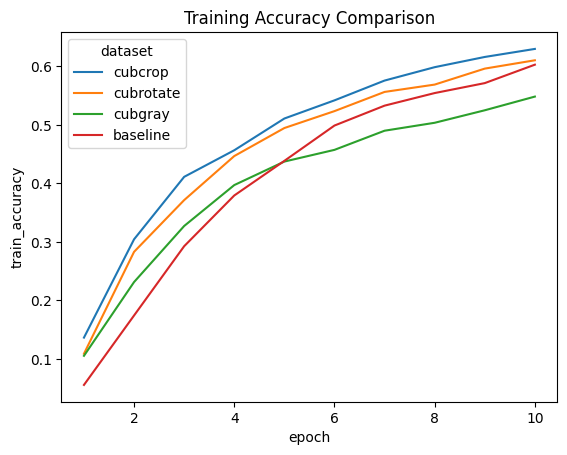

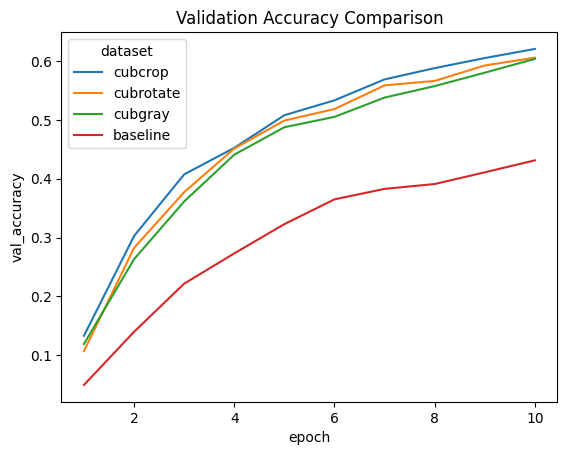

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df, x='epoch', y='train_accuracy', hue='dataset')  # Note: change 'train_acc' to 'train_accuracy'
plt.title('Training Accuracy Comparison')
plt.show()

sns.lineplot(data=df, x='epoch', y='val_accuracy', hue='dataset')  # Note: change 'val_acc' to 'val_accuracy'
plt.title('Validation Accuracy Comparison')
plt.show()


Define Model(ResNet50).

In [36]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [37]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        # correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)

        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [38]:
def calc_accuracy(model, dataloader):
    model.eval()
    model.cuda()

    top1 = AverageMeter()
    top5 = AverageMeter()

    for idx, (inputs, labels) in enumerate(dataloader):

        inputs, labels = inputs.cuda().float(), labels.cuda().long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))

    return top1 ,top5

In [40]:
num_of_classes=200

In [41]:
model_name_base = "resnet50_"
lr = 0.001
momentum=0.9
epochs=10
for name, data_loader in datasets.items():
    print(f"Training on {name} dataset")
    model_name = f"{model_name_base}_{name}"
    resnet50 = models.resnet50(pretrained=False)
    num_ftrs = resnet50.fc.in_features
    resnet50.fc = nn.Linear(num_ftrs, num_of_classes)  # Replace with your number of classes
    resnet50.load_state_dict(torch.load(f"./model_weights/{model_name}.pth"))
    # Move to appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    resnet50 = resnet50.to(device)

    # Set to evaluation mode
    resnet50.eval()
    # Run inference
    print(model_name)
    top1 ,top5 = calc_accuracy(resnet50, baseline_val_loader)
    print("top1 avg", top1.avg)
    print("top5 avg",top5.avg)



Training on cubcrop dataset


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


resnet50__cubcrop
top1 avg tensor(62.0469, device='cuda:0')
top5 avg tensor(87.9358, device='cuda:0')
Training on cubrotate dataset
resnet50__cubrotate
top1 avg tensor(60.5626, device='cuda:0')
top5 avg tensor(88.0048, device='cuda:0')
Training on cubgray dataset
resnet50__cubgray
top1 avg tensor(60.3555, device='cuda:0')
top5 avg tensor(86.7276, device='cuda:0')
Training on baseline dataset
resnet50__baseline
top1 avg tensor(43.1136, device='cuda:0')
top5 avg tensor(74.3528, device='cuda:0')


Validation Metric